In [1]:
from datasets import Dataset
from config import postprocessing

similar_is_equal_list = postprocessing.similar_is_equal_list
similar_is_equal_threshold_list = postprocessing.similar_is_equal_threshold_list

/Users/pietroferrazzi/Desktop/dottorato/mistral_finetuning/.env/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
import json
import re

class OutputCleaner():
    def __init__(self) -> None:
        pass
  
    def _remove_space_from_dict_keys(self, model_ouput_list: list) -> list:
        """
        Remove the spaces from the keys of a dictionary. E.g., [{"entity ": "value"}] -> [{"entity": "value"}]

        Args:
        model_ouput_list (dict): the list of dictionaries to be cleaned

        return:
        list: the cleaned list of dicts
        """
        out = []
        for dict in model_ouput_list:
            out.append({k.replace(' ', ''): v for k, v in dict.items()})
        return out
    
    def _drop_duplicates(self, model_response: list) -> str:
        """
        Drop the duplicates from a list. This is useful when the model output contains the same entity multiple times.

        Args:
        model_response (str): the model response with no duplicates
        """
        try :
            return list({v['entity']:v for v in model_response}.values())
        except Exception as error:
            model_response = self._remove_space_from_dict_keys(model_response)
            return list({v['entity']:v for v in model_response}.values())
        
    def _assess_model_output(self, model_response: str) -> bool:
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        """
        good_format = True
        try :
            res = json.loads(model_response)
            # print( res)
        except:
            good_format = False
        return good_format

            
    def _remove_json_special_chars(self, string):
        chars = ['\xa0']
        for char in chars:
            string = string.replace(char, ' ')
        return string
    
    def _clean_ground_truth(self, example: dict) -> dict:
        ground_truth = example['ground_truth']
        ground_truth = self._remove_json_special_chars(ground_truth)
        if ground_truth == ']':
            ground_truth = '[' + ground_truth
        return({'ground_truth': ground_truth})

    def _clean_model_output(self, example: dict,  wrong_keys_to_entity:bool, latest_version:bool=True) -> dict:
        """
        Postprocess the model output to return a json like formatted string that can be used to compute the F1 score.

        Args:
        model_output (str): the model output as it is returned by the model. The processing of the output is done in the function
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped

        return:
        dict: the model response

        """
        def has_unclosed_square_brackets(s:str)  -> bool:
            count = 0
            for char in s:
                if char == '[':
                    count += 1
                elif char == ']':
                    count -= 1
                    if count < 0:
                        return True
            return count > 0
        
        def has_unopen_square_brackets(s:str)  -> bool:
            count = 0
            for char in s:
                if char == '[':
                    count -= 1
                elif char == ']':
                    count += 1
                    if count > 0:
                        return True
            return count > 0
        
        def is_empty_list(string:str)  -> bool:
            if string=='[]':
                return True
            return False
        
        def is_list_of_lists(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, list) for item in tmp):
                    return True
            return False
        
        def is_list_of_dicts(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, dict) for item in tmp):
                    return True
            return False
        
        def is_list_of_lists_and_dict(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                found_dict = False
                found_list = False
                for element in tmp:
                    if isinstance(element, list):
                        found_list = True
                    elif isinstance(element, dict):
                        found_dict = True
                    if found_list and found_dict:
                        return True
            return False
        
        def is_list_of_strings(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, list) and all(isinstance(item, str) for item in tmp):
                    return True
            return False
        
        def is_string(string:str)  -> bool:
            if self._assess_model_output(string):
                tmp = json.loads(string)
                if isinstance(tmp, str):
                    return True
            return False
        
        def are_entities_extracted_as_dict_keys_instead_of_values(string:str, example:dict) -> bool:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                keys = [key for item in tmp for key in item.keys()]
                if 'entity' not in keys:
                    if all(entity in example['sentence'] for entity in keys):
                        return True
            return False
        
        
        def convert_wrong_keys_into_entity(string:str) -> list[str]:
            if is_list_of_dicts(string):
                tmp = json.loads(string)
                tmp = [str({"entity":v}) for el in tmp for v in el.values()]
                return tmp
            else:
                return []


        def only_dicts_with_key_entity(string:str, wrong_keys_to_entity:bool) -> (bool, str):
            """
            Extract only the dictionaries with the key 'entity' in the list of dictionaries in the string
            
            Args:
            string (str): the string to be cleaned
            wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'
            """
            els_between_curly = re.findall(r'\{(.+?)\}', string)
            clean = [el for el in els_between_curly if el.startswith('"entity"') or el.startswith("'entity'")]
            clean = ['{' + el + '}' for el in clean]
            dirty = []
            if wrong_keys_to_entity:
                dirty = [el for el in els_between_curly if (not el.startswith('"entity"')) and (not el.startswith("'entity'"))]
                dirty = ['{' + el + '}' for el in dirty]
                dirty = '[' + ', '.join(dirty) + ']'
                cleaned_dirty = convert_wrong_keys_into_entity(dirty)
                out = '[' + ', '.join(clean) + ', '.join(cleaned_dirty) +  ']' # 
            else:
                out = '[' + ', '.join(clean) + ']'
            out = out.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            operations_performed = False
            if len(clean) != len(els_between_curly):
                operations_performed = True
            if is_empty_list(out):
                return operations_performed, '[{"entity":""}]'
            return operations_performed, str(out)
        

        model_output = example['model_responses']
        
        # print('ORIGINAL MODEL OUTPUT: ', model_output)
        
        if model_output is None or is_empty_list(model_output):
            return {'model_output':'[{"entity":""}]'}
        
        model_output = self._remove_json_special_chars(model_output)
                
        if are_entities_extracted_as_dict_keys_instead_of_values(model_output, example):
            tmp = json.loads(model_output)
            tmp = [{"entity":k} for el in tmp for k in el.keys() ]
            tmp = str(tmp)
            return {'model_output':tmp}
        
        if is_list_of_lists_and_dict(model_output):
            tmp = json.loads(model_output)
            for el in tmp:
                if isinstance(el, list):
                    tmp = str(el)
                    # print('is_list_of_lists_and_dict')
                    return {'model_output':tmp}
                
        if is_list_of_lists(model_output):
            tmp = json.loads(model_output)
            tmp = str(tmp[0])
            # print('is_list_of_lists')
            return {'model_output':tmp}

        if is_list_of_strings(model_output):
            tmp = json.loads(model_output)
            tmp = [{"entity":el} for el in tmp]
            tmp = str(tmp)
            # print('is_list_of_strings')
            return {'model_output': tmp}
        
        if is_string(model_output):
            # model_output = model_output.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(" \'", " \"")
            # print('PULITO: ', model_output)
            tmp = json.loads(model_output)
            if all(el in tmp for el in ['{', 'entity', '}']):
                return {'model_output':tmp}
            tmp = [{"entity":tmp}]
            tmp = str(tmp)
            #print('is_string')
            return {'model_output':tmp}

        
        if latest_version:
            model_output = self._extract_text_between_curl_brackets(model_output)
            #print( 'THE EXTRACTED MODEL OUTPUT: ', model_output)
            #last attempt to clean 
            model_output = self._clean_text_between_curl_brackets(model_output)
            cleaning_done, cleaned_model_output = only_dicts_with_key_entity(model_output, wrong_keys_to_entity=wrong_keys_to_entity)
            if cleaning_done:
                model_output = cleaned_model_output
            
            
            if is_list_of_dicts(model_output):
                tmp = json.loads(model_output)
                #tmp = [item for item in tmp if 'entity' in item.keys()]
                return {'model_output':str(tmp)}
            
            else: 
                # print('NOT CLEANED: ', model_output, '\n\n')
                return {'model_output':'[{"entity":""}]'}
        


        if not latest_version:
            if has_unopen_square_brackets(model_output):
                last_bracket_index = model_output.rfind('],') # keep the closed list
                model_output = '[' + model_output[:last_bracket_index+1] 
                return {'model_output':model_output} 
            
            tmp = re.findall(r'\[\{(.+?)\}\]', model_output)
            if len(tmp) != 0:
                tmp = '[{' + tmp[0] + '}]'
                if self._assess_model_output(tmp):
                    return {'model_output':tmp}
                
            if has_unclosed_square_brackets(model_output):
                last_bracket_index = model_output.rfind('},') # find the last complete entity
                model_output = model_output[:last_bracket_index+1] + ']' 
                return {'model_output':model_output} 


            if model_output.strip()[0] == '{':
                tmp = '[' + model_output + ']'
                if self._assess_model_output(tmp):
                    return {'model_output':tmp}
                else:
                    last_bracket_index = model_output.rfind('},') # find the last complete entity
                    model_output = '[' + model_output[:last_bracket_index+1] + ']'
                    return {'model_output':model_output}
                
            if model_output.strip().startswith('[['):
                tmp = model_output[1:]
                if self._assess_model_output(tmp):
                    return {'model_output':tmp}

            print('THIS IS A BROKEN ROW: ', model_output)

            return {'model_output':model_output}
    
    def _extract_text_between_curl_brackets(self, model_output: str) -> str:
        """
        Extract the text between the curl brackets of the model output, as enitties are usually outputted in this format: {"entity": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.findall(r'\{(.+?)\}', model_output)
        cleaned_output = ['{'+ el +'}' for el in text_between_curl_brackets]
        cleaned_output = '[' + ', '.join(cleaned_output) + ']'
        return cleaned_output
    

    def _clean_text_between_curl_brackets(self, text_between_curl_brackets: str) -> str:
        """
        Clean the text between the curl brackets of the model output, as entities are usually outputted in this format: {"key": "value"}

        Args:
        model_output (str): the example from the dataset

        """
        text_between_curl_brackets = re.sub(r'",(.+?)}', r'"}', text_between_curl_brackets)
        return(text_between_curl_brackets)

        # list_of_dicts = json.loads(text_between_curl_brackets)
        # list_of_dicts_str = [str(item) for item in list_of_dicts]
        # out = []
        # print('list_of_dicts: ', list_of_dicts_str)
        # if ' '.join(list_of_dicts_str).count(':') > len(list_of_dicts):
        #     for item in list_of_dicts:
        #         if len(item) > 1:
        #             item = self._keep_only_one_keyVal_from_dict(item)
        #         out.append(item)
        #return str(out)

    # def _keep_only_one_keyVal_from_dict(dict: dict) -> dict:
    #     """
    #     Keep only one key-value pair from a dictionary. This is useful when the model outputs a dictionary with more than one key-value pair.

    #     Args:
    #     dict (dict): the dictionary to be cleaned

    #     return:
    #     dict: the cleaned dictionary
    #     """
    #     k_first = "entity"
    #     if k_first not in dict.keys():
    #         k_first = list(dict.keys())[0]
    #     return {k_first:dict[k_first]}

    
    def apply_cleaning(self, data, wrong_keys_to_entity) -> None:
        """
        Apply the cleaning to the model output and return the cleaned response in a new cloumn called 'model_output

        Args:
        model_output (str): the model output as it is returned by the model. The processing of the output is done in the function
        wrong_keys_to_entity (bool): if True, the function also extracts the dictionaries with keys different from 'entity', converting the keys into 'entity'. If not, all keys that are not 'entity' are dropped

        return:
        str: the model response, i.e. the model output without the instruction
        """
        data = data.map(lambda x: self._clean_ground_truth(x), remove_columns=['ground_truth'])
        data = data.map(lambda x: self._clean_model_output(x, wrong_keys_to_entity)) 
        return data

In [25]:
input_string = '{"entity": "disease"}, {"entity": "autoimmune disease"}] {"entity": "Her", "any"}]'



# Delete the characters between each occurrence of '",' and '}'
output_string = re.sub(r'",(.+?)}', r'"}', input_string)
output_string

'{"entity": "disease"}, {"entity": "autoimmune disease"}] {"entity": "Her"}]'

In [ ]:
file = 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.01_2_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = False
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))
cleaned_data[0]
evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)


In [ ]:
import glob
import pandas as pd
#adapters_list = generate_ft_adapters_list("enlayer1_3epochs_4bits__ft_params")
evaluators = {}
csv_files = glob.glob('data/test_data_processed/*.csv') #'data/mistral/test_data_processed/*.csv'
#csv_files = ['data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_2_0.0002.csv']
evaluation_results = pd.DataFrame(columns=['file', 'similar_is_equal', 'similar_is_equal_threshold', 'f1_score', 'precision', 'recall'])

print(evaluation_results)
for file in csv_files:
    if file.strip().endswith('0.002.csv'):
        continue
    print("FILE: " , file)
    eval_data = Dataset.from_csv(file) 
    output_cleaner = OutputCleaner()
    cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)
    for similar_is_equal in similar_is_equal_list:
        if similar_is_equal:
            for similar_is_equal_threshold in similar_is_equal_threshold_list:
                # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                                
                try:
                    evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                    evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal_threshold, similar_is_equal_threshold=similar_is_equal_threshold)
                    evaluators[f"{file}_SimilarIsEqual{similar_is_equal}_Threshold{similar_is_equal_threshold}"] = evaluator
                    evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                    # print('DONE')
                except:
                    break
        elif not similar_is_equal:
            # evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
            # evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
            # evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
            # evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
            
            try:
                evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
                evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=100)
                evaluators[f"{file}_SimilarIsEqual{similar_is_equal}"] = evaluator
                evaluation_results.loc[len(evaluation_results)] = {'file': file, 'similar_is_equal': similar_is_equal, 'similar_is_equal_threshold': similar_is_equal_threshold, 'f1_score': evaluator.evaluation_table['f1'], 'precision': evaluator.evaluation_table['precision'], 'recall': evaluator.evaluation_table['recall']}
                # print('DONE')
            except:
                #print('SKIPPING THIS')
                break


In [15]:
## evaluation_results.to_csv('data/mistral/evaluation_results/results.csv', index=False)

In [23]:
evaluation_results[evaluation_results['similar_is_equal_threshold'] >= 100].sort_values(by='f1_score', ascending=False)['file'].to_list()[0:5]

['data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_16_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_4_0.0002.csv',
 'data/test_data_processed/maxNewTokensFactor4_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_32_32_0.05_8_0.0002.csv']

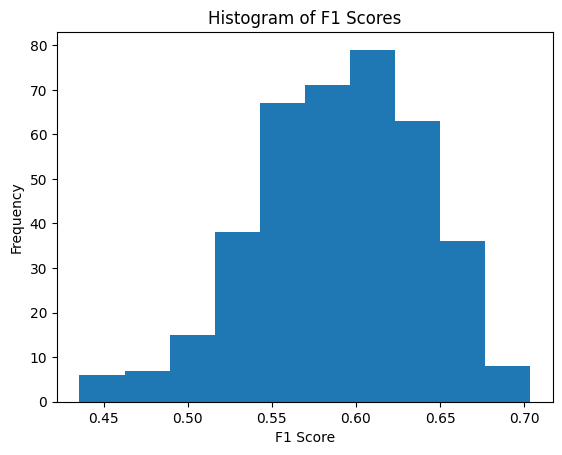

In [13]:
f1 = []
for _,eval in evaluators.items():
    f1.append(eval.evaluation_table['f1'])

import matplotlib.pyplot as plt

plt.hist(f1)
plt.xlabel('F1 Score')
plt.ylabel('Frequency')
plt.title('Histogram of F1 Scores')
plt.show()


### One Run

In [15]:
file = 'data/test_data_processed/maxNewTokensFactor8_nShotsInference2_Mistral-7B-Instruct-v0.2_adapters_en.layer1_4_torch.bfloat16_64_32_0.01_2_0.0002.csv'
eval_data = Dataset.from_csv(file) 
#display(eval_data.to_pandas().head(3))
output_cleaner = OutputCleaner()
similar_is_equal = False
similar_is_equal_threshold = 80
cleaned_data = output_cleaner.apply_cleaning(eval_data, wrong_keys_to_entity=False)#.select(range(138,139))

evaluator = Evaluator(data=cleaned_data, offset=False, output_cleaner=output_cleaner)
evaluator.generate_evaluation_table(similar_is_equal=similar_is_equal, similar_is_equal_threshold=similar_is_equal_threshold)


ORIGINAL model_response:  [{'entity': 'diagnosed'}, {'entity': 'unveiled'}, {'entity': 'referred'}, {'entity': 'hypokalemia'}, {'entity': 'hypertension'}, {'entity': 'dyslipidemia'}, {'entity': 'diabetes mellitus'}, {'entity': 'A 46-year-old man'}, {'entity': '4-months before'}, {'entity': '1-month earlier'}]
PROVO QUESTO [{'entity': 'diagnosed'}, {'entity': 'unveiled'}, {'entity': 'referred'}, {'entity': 'hypokalemia'}, {'entity': 'hypertension'}, {'entity': 'dyslipidemia'}, {'entity': 'diabetes mellitus'}, {'entity': 'A 46-year-old man'}, {'entity': '4-months before'}, {'entity': '1-month earlier'}]
Expecting property name enclosed in double quotes: line 1 column 3 (char 2)
PROVO QUESTO [{"entity": "hypertension"}, {"entity": "dyslipidemia"}, {"entity": "diagnosed"}, {"entity": "mellitus"}, {"entity": "referred"}, {"entity": "hypokalemia"}, {"entity": "new-onset diabetes mellitus"}, {"entity": "A 46-year-old man"}, {"entity": "4-months"}, {"entity": "1-month"}]
PARSED model_response:

{'evaluation':      TP  FP  FN
 0     6   4   4
 1     2   0   2
 2     2   3   2
 3     3   1   2
 4     1   0   1
 ..   ..  ..  ..
 676   1   0   3
 677   3   3   1
 678   3   0   0
 679   3   6   2
 680   2   7   2
 
 [681 rows x 3 columns],
 'precision': 0.5382850587897906,
 'recall': 0.5089479392624728,
 'f1': 0.5232055749128919}

In [6]:
s = """ [{'entity': 'complaining'}, {'entity': 'wound'}, {'entity': 'pain'}, {'entity': 'bleeding'}, {'entity': "a 'wound in the mouth'"}, {'entity': 'A male'}, {'entity': '63 years old'}, {'entity': '6 months'}] """
s = s.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
s
#json.loads(s)

' [{"entity": "complaining"}, {"entity": "wound"}, {"entity": "pain"}, {"entity": "bleeding"}, {"entity": "a \'wound in the mouth\'"}, {"entity": "A male"}, {"entity": "63 years old"}, {"entity": "6 months"}] '

In [3]:
import json
import re
import pandas as pd
from datasets import Dataset        
from fuzzywuzzy import fuzz


class Evaluator():

    def __init__(self,  data: Dataset, offset:bool, output_cleaner) -> None:
        self.offset = offset
        self.data = data
        self.cleaner = output_cleaner
        pass
    
    def _assess_model_output(self, model_response: str) -> (bool, str):
        """
        Check if the model output is in the right format. If not, return False.
        
        Args:
        model_output (str): the postprocessed model output after beeing passed to _postprocess_model_output()

        return:
        bool: True if the format is correct, False otherwise
        str: the model output in the adjusted format
        """
        good_format = True
        try :
            out = json.loads(model_response)
            if isinstance(out, dict):
                model_response = '[' + model_response + ']'
        except Exception as error:
            #print(error)
            if hasattr(error, 'msg'):
                if error.msg.startswith('Expecting property name enclosed in double quotes'):
                    model_response = model_response.replace("{\'", "{\"").replace("\'}", "\"}").replace("\'ent", "\"ent").replace("ty\'", "ty\"").replace(": \'", ": \"")
                    out = json.loads(model_response)
                    # print('out ', out)
                    if isinstance(out, dict):
                        model_response = '[' + model_response + ']'
                        good_format = True
                # if error.msg.startswith('Extra data'):
            else:
                #print('MODEL RESPNSE: ', model_response)
                good_format = False
        if not good_format:
            model_response = re.findall(r'\[\{(.+?)\}\]', model_response)
            if len(model_response) != 0:
                model_response = '[{' + model_response[0] + '}]'
                good_format = True
                try :
                    json.loads(model_response)
                except Exception as error:
                    good_format = False
            else:
                good_format = False
        return good_format, model_response

    def _parse_json(self, model_response: str, drop_duplicates: bool = True) -> dict:
        """
        Parse the model output to extract the entities and their offsets if present.
        
        Args:
        model_response (str): the model response 
        drop_duplicates (bool): if True, drop the duplicates in the model response
        """
        good_format, model_response = self._assess_model_output(model_response)
        if model_response == []:
            model_response = '[{"entity":""}]'
        if self.offset and good_format:
            output = json.loads(model_response)
            if drop_duplicates:
                output = self.cleaner._drop_duplicates(output)
            entities = [entity["entity"] for entity in output]
            offsets = [entity["offset"] for entity in output]
            return {"entities": entities, "offsets": offsets}
        elif (not self.offset) and good_format:
            output = json.loads(model_response)
            # print('OUTPUT: ', type(output))
            if drop_duplicates:
                output = self.cleaner._drop_duplicates(output)
            entities = [entity["entity"] for entity in output]
            # print('ENTITIES: ', entities)
            return {"entities": entities}
        if not good_format:
            return {"entities": []}


    def _entity_similar_to_ground_truth_entity(self, entity_in_model_resonse: str, entity_in_ground_truth: str, threshold: int) -> (bool, str):
        """
        Check if two entities are similar. This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_resonse (str): an entity in the model response
        entity_in_ground_truth (str): an entity in the ground truth
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entities are similar, False otherwise
        str: the entity in the ground truth if the entities are similar, the entity in the model response otherwise
        """
        def __preprocess_string__(string):
            # Remove common articles and noise words
            noise_words = ["a", "an", "the", "of"]
            words = string.split()
            filtered_words = [word for word in words if word.lower() not in noise_words]
            return ' '.join(filtered_words)

        if entity_in_model_resonse == entity_in_ground_truth:
            return True, entity_in_ground_truth
        
        normalized_string = __preprocess_string__(entity_in_model_resonse)
        normalized_entity_ground_truth = __preprocess_string__(entity_in_ground_truth)
        if normalized_string == normalized_entity_ground_truth:
            # print('entity_ground_truth:', entity_in_ground_truth)
            return True, entity_in_ground_truth
        
        similarity = fuzz.ratio(entity_in_model_resonse.lower(), entity_in_ground_truth.lower())
        if similarity >= threshold:
            #print('VERO 2')
            return True, entity_in_ground_truth
        return False, entity_in_model_resonse
        
    def entity_in_ground_truth_list(self, entity_in_model_resonse: str, ground_truth: list, model_response_list: list, threshold: int) -> (bool, str):
        """
        Check if an entity is in the ground truth. This is useful when the model output is not exactly the same as the ground truth.

        Args:
        entity_in_model_resonse (str): an entity in the model response
        ground_truth (list): the ground truth
        model_response_list (list): the list off all entities already in the answer
        threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        return:
        bool: True if the entity is in the ground truth, False otherwise
        str: the entity in the ground truth if the entity is in the ground truth, the entity in the model response otherwise
        """
        model_response_list
        strings = []
        for entity_in_ground_truth in ground_truth:
            is_in, string = self._entity_similar_to_ground_truth_entity(entity_in_model_resonse, entity_in_ground_truth, threshold)
            if is_in:
                strings.append(string)
        #if entity_in_model_resonse in ground_truth and entity_in_model_resonse
        if len(strings) > 0:
            if entity_in_model_resonse in strings: # se ho estratto la stessa, ritorno se stessa
                return entity_in_model_resonse
            else: #
                # print('sto analizzando: "', entity_in_model_resonse, '" e ho trovato: ', strings)
                return strings[-1]
        return entity_in_model_resonse
    


    def _extract_TP_FP_FN(self, model_response: str, ground_truth: str, similar_is_equal:bool, similar_is_equal_threshold: int) -> [int, int, int]:
        """
        Compute the F1 score, the precision and the recall between the model output and the ground truth

        Args:
        model_output (str): the model output as it is returned by the model. The processing of the output is done in the function
        ground_truth (str): the ground truth in json format.
        similar_is_equal (bool): if True, the function will consider similar entities as equal. The default value is False.
        similar_is_equal_threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely different, 100 is the same.

        """
        # print('ORIGINAL model_response: ', model_response)
        model_response = self._parse_json(model_response)
        ground_truth = self._parse_json(ground_truth)
        model_response = model_response["entities"]
        ground_truth = ground_truth["entities"]
        # print('PARSED model_response: ', model_response)
        if similar_is_equal:
            for i, response_entity in enumerate(model_response):
                model_response[i] = self.entity_in_ground_truth_list(response_entity, ground_truth, model_response, similar_is_equal_threshold)
        # print('NEW model_response: ', model_response)
        # print('PARSED GROUND TRUTH: ', ground_truth, '\n\n')

        TP = len(set(model_response).intersection(set(ground_truth)))
        FP = len(set(model_response).difference(set(ground_truth)))
        FN = len(set(ground_truth).difference(set(model_response)))
        # F1 = 2 * TP / (2 * TP + FN + FP)
        return [TP, FP, FN]
    
    def generate_evaluation_table(self, similar_is_equal:bool, similar_is_equal_threshold: int) -> dict:
        """
        Generate the evaluation table for the model output and the ground truth.

        Args:
        similar_is_equal (bool): if True, the function will consider similar entities as equal. The default value is False.
        similar_is_equal_threshold (int): the threshold to consider the entities similar. The default value is 80. 0 is completely
        different, 100 is the same.

        return:
        dict: the evaluation table
        """
        metrics_list = []
        for i, res in enumerate(self.data['model_output']):
            try:
                # print('FINAL OUTPUT: ', res)
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth'][i], similar_is_equal, similar_is_equal_threshold))
            except Exception as error:
                # print(print(self.data[i]))
                metrics_list.append(self._extract_TP_FP_FN(res, self.data['ground_truth'][i], similar_is_equal, similar_is_equal_threshold))

        metrics_dataframe = pd.DataFrame(metrics_list, columns=['TP', 'FP', 'FN'])
        summary = metrics_dataframe.sum()
        precision = summary['TP'] / (summary['TP'] + summary['FP'])
        recall = summary['TP'] / (summary['TP'] + summary['FN'])
        f1 = 2 * (precision * recall) / (precision + recall)
        self.evaluation_table = {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}
        return {'evaluation': metrics_dataframe, 'precision':precision, 'recall':recall, 'f1':f1}

/Users/pietroferrazzi/Desktop/dottorato/mistral_finetuning/.env/lib/python3.9/site-packages/fuzzywuzzy/fuzz.py:11: UserWarning: Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning
  warnings.warn('Using slow pure-python SequenceMatcher. Install python-Levenshtein to remove this warning')
